<a href="https://colab.research.google.com/github/Akash-sk-bio/Loan_Default_Prdiction/blob/main/Loan_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Step 1: Data Understanding and Preprocessing

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Load dataset
df = pd.read_csv('Loan_default.csv')

# Basic data inspection
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [3]:
# Handling missing data
# Assuming numeric missing values will be imputed with the mean and categorical with the mode
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

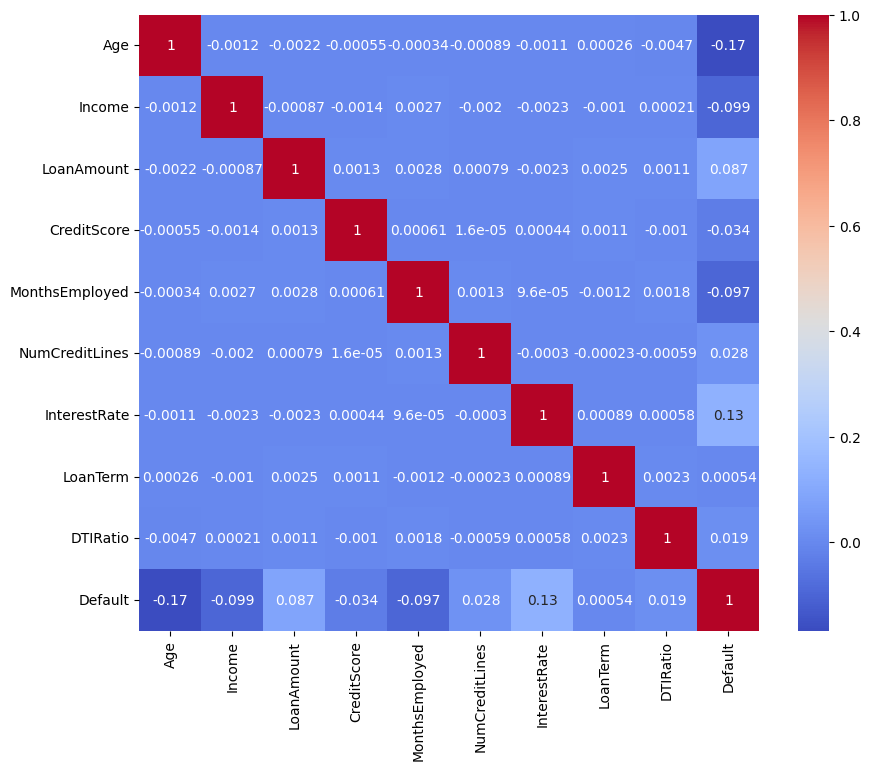

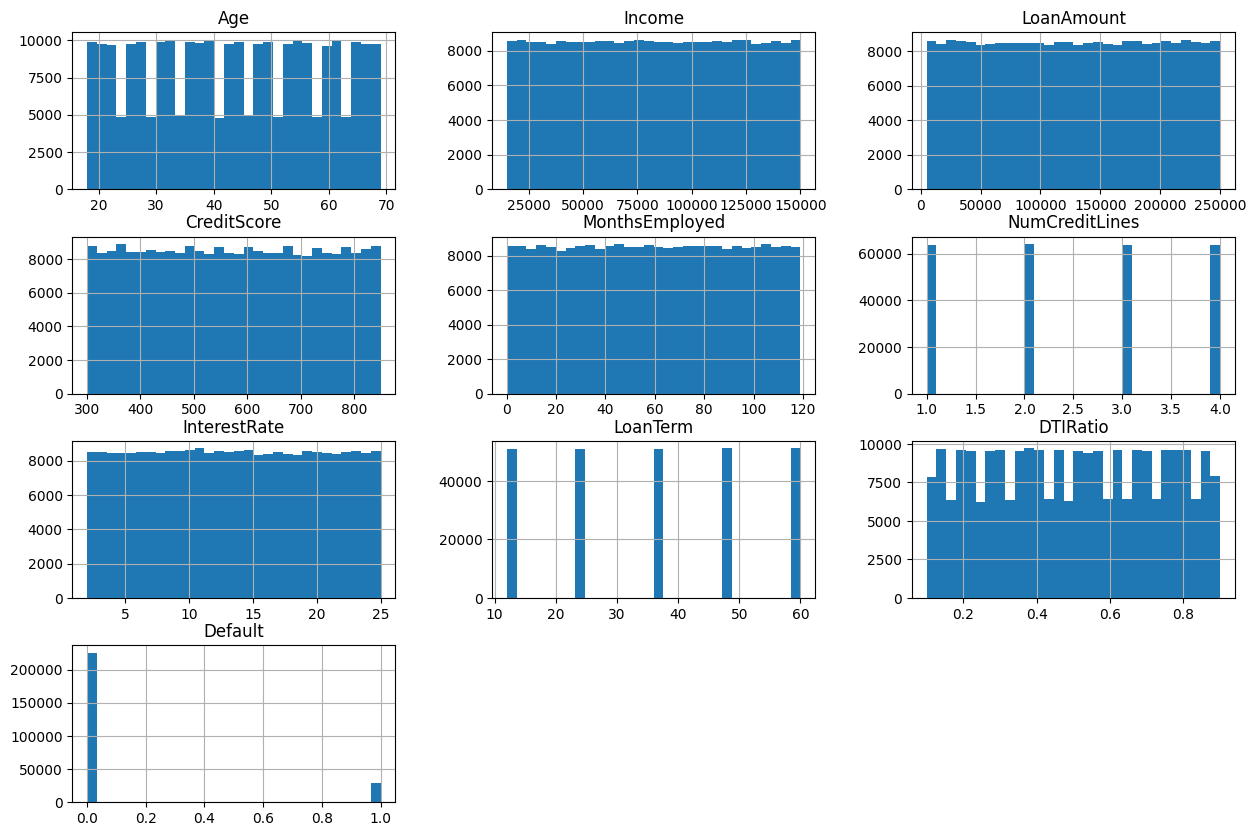

In [4]:
# Step 2: Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import seaborn as sns

# Filter out only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.show()

# Histograms for each feature
numeric_df.hist(bins=30, figsize=(15,10))
plt.show()

In [9]:
# Step 2: Data Preprocessing
# Handle missing values
df.isnull().sum()  # Checking for missing values
# Assuming 'target' is the column representing loan default (1 for default, 0 for non-default)
target = 'Default'  # Update with correct column name

# Split the dataset into features (X) and target (y)
X = df.drop(columns=[target])
y = df[target]

In [10]:
# Step 3: Handling Categorical and Numerical Columns
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Defining the data preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [11]:
# Step 4: Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Step 5: Build Gradient Boosting Model
gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier())])

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5]
}

grid_search = GridSearchCV(gb_pipeline, param_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters from GridSearch
print("Best parameters:", grid_search.best_params_)

# Step 6: Model Evaluation
y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", roc_auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Gradient Boosting (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [ ]:
# Step 7: Feature Importance
gb_model = grid_search.best_estimator_.named_steps['classifier']
feature_importances = gb_model.feature_importances_

# Visualizing Feature Importances
plt.figure(figsize=(10, 8))
plt.barh(X.columns, feature_importances, color='teal')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Loan Default Prediction')
plt.show()